In [1]:
import re
from collections import Counter
import contractions
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

In [ ]:
def get_comments(game_id):
    comments_per_page = 100   
    all_comments = []
    page = 1
    retries = 3

    while True:
        url = f'https://boardgamegeek.com/xmlapi2/thing?id={game_id}&stats=1&ratingcomments=1&page={page}'
        try:
            response = requests.get(url, timeout=10)
        except requests.Timeout:
            retries -= 1
            if retries == 0:
                break
            time.sleep(2)  
            continue

        if response.status_code != 200:
            break
        
        soup = BeautifulSoup(response.content, 'lxml-xml')
        
        comments = soup.find_all('comment')
        if not comments:
            break  
            
        for comment in comments:
            user = comment['username']
            rating = comment['rating']
            text = comment['value']
            if text and rating:  # Interesują nas tylko pozycje z wypełnioną oceną liczbową i komentarzem
                all_comments.append({'user': user, 'rating': rating, 'comment': text})
        
        page += 1

    game_name = soup.find('name', type='primary')['value'] if soup.find('name', type='primary') else 'Unknown'

    return {'game_name': game_name, 'ratings_comments': all_comments}

game_id = '174430'  # Gloomhaven, #1
game_details = fetch_all_comments(game_id)

if game_details:
    df = pd.DataFrame(game_details['ratings_comments'])
    print(f"Game Name: {game_details['game_name']}")
    print(f"Total Comments: {len(game_details['ratings_comments'])}")
    print(df)

    # Zapis do csv, backup
    df.to_csv(f"{game_details['game_name'].replace(' ', '_')}_comments.csv", index=False)


In [3]:
df = pd.read_csv("Gloomhaven_comments.csv")
df.head()

,user,rating,comment
0,Garroc,10.0,Kickstarter
1,Chris Coyote,10.0,Awesome. By far the best dungeon crawler I hav...
2,Beaushek,10.0,"If you know and want what you're getting, you'..."
3,Iguloy,10.0,Kickstarted. Standee version. Owned expansion ...
4,rlphay,10.0,After play testing this game early in the deve...


# Eksploracja danych

In [4]:
pd.set_option('display.max_colwidth', 500)
df.head(10)

,user,rating,comment
0,Garroc,10.0,Kickstarter
1,Chris Coyote,10.0,"Awesome. By far the best dungeon crawler I have played yet, with an ingenious legacy system on top. Highly recommended."
2,Beaushek,10.0,"If you know and want what you're getting, you'll be thrilled. The game is big, stressful, and interesting. The value is, of course, huge. I see two issues with the game. The rulebook is very big and you'll need your own storage solution. Normally, I'll dock part of a point because of issues like that, but this might be my favorite game of all time. I'm not docking points for needing to use a Plano box, when this game has occupied all of my thoughts. It's excellent."
3,Iguloy,10.0,"Kickstarted. Standee version. Owned expansion : Forgotten circles WOW. I can't emphasize enough how amazing this game is. Best game of 2017 for me, hands down. This is like a dream come true, I couldn't have asked for better. If you like Legacy games and dungeon crawls... please make yourself a gift and get this. You cannot not play this! #1 BEST Dungeon crawl #1 BEST Legacy game #1 BEST Cooperative game Also one of my SO's favorite games. Update after 25 plays : I have now played 25 gam..."
4,rlphay,10.0,After play testing this game early in the development I can say that it has come a long way and well worth getting. There is high replay value in this game and endless adventures that make it worth every penny spent. And the unique gameplay is unlike anything out there so you will not be playing the different version of some other game.
5,crwills,10.0,Kickstarted
6,WeeGee,10.0,Very fun game but I found it too difficult with two characters. Don't have the table space to do 3 characters.
7,mcscowl,10.0,"One of my absolute favorite games. Not saying this as the graphic designer, but as a gamer."
8,vardamir,10.0,"Damn, I love this game (So much). Coop wasn't my cup of tea, but this one is an exception. I love how players plan their turns, initiative orders, hand management, character progressions, enemy AI, the campaign and story line, the theme and illustrations, various characters with different play styles, retirement and deck building element in the game. Definitely beats Eclipse from the throne."
9,davidcoleman,10.0,Gift


In [5]:
df.tail(10)

,user,rating,comment
8613,rbeatnick,1.0,"I tried to like it but it's Too fiddly, it take ages to setup and there's no story"
8614,MotherMary,1.0,"Yet another game for suckers playing the Kickstarter game. Yet another story of friends falling for hype, squealing when the game comes in, and then a few weeks later it is as if the game never existed. There are many reasons you see more copies of this game than anything else at swaps, and going for pennies on the dollar. There's only one for why it is ranked so high - hype."
8615,Survivor Ivy,1.0,"Intensely boring, unbelievable levels of tedious admin, unplayably slow in a group of 4."
8616,Pipinghot,1.0,"Excruciatingly painful game play. It's a puzzle game disguised and an RPG/adventure game. It's a great example of what it's supposed to be, a complex puzzler. But It's pretty absurd that it's one of the all-time top rated games, that rating demonstrates how the pool of people who rate games here are badly skewed towards high-complexity games. Only try this if you want a game that will set your brain on fire, otherwise steer clear of it."
8617,Stevo_NS,1.0,My copy is now worthless thanks to a replacement edition. Backers should avoid because your second edition will be replaced by a third edition.
8618,zerbia88,1.0,Way too much overhead.
8619,civilvictim,1.0,Way too difficult and overcomplicated at certain points.
8620,vasto44lorde,1.0,Balance for fake 10s
8621,NackAtDaMaww,1.0,Do not understand the hype of this game. Took way too long to set up and play and the card mechanic is not as fascinating as everyone says.
8622,Gamil_,1.0,"No, just no, in all of the available forms."


# Dalsze czyszczenie danych

In [6]:

def preprocessor(comment):
    # małe litery
    comment = comment.lower()
    # zamiana "skróceń" (you'll, we're), itd.:
    comment = contractions.fix(comment)
    # usunięcie znaków innych niż alfanumeryczne
    comment = re.sub('[^a-z0-9\s]', '', comment)
    return comment
    

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\marta\AppData\Local\Temp\ipykernel_16252\3489571063.py:7: SyntaxWarning: invalid escape sequence '\s'
  comment = re.sub('[^a-z0-9\s]', '', comment)


In [7]:
df['comment_preprocessed'] = df['comment'].apply(preprocessor)

In [8]:
df.head()

,user,rating,comment,comment_preprocessed
0,Garroc,10.0,Kickstarter,kickstarter
1,Chris Coyote,10.0,"Awesome. By far the best dungeon crawler I have played yet, with an ingenious legacy system on top. Highly recommended.",awesome by far the best dungeon crawler i have played yet with an ingenious legacy system on top highly recommended
2,Beaushek,10.0,"If you know and want what you're getting, you'll be thrilled. The game is big, stressful, and interesting. The value is, of course, huge. I see two issues with the game. The rulebook is very big and you'll need your own storage solution. Normally, I'll dock part of a point because of issues like that, but this might be my favorite game of all time. I'm not docking points for needing to use a Plano box, when this game has occupied all of my thoughts. It's excellent.",if you know and want what you are getting you will be thrilled the game is big stressful and interesting the value is of course huge i see two issues with the game the rulebook is very big and you will need your own storage solution normally i will dock part of a point because of issues like that but this might be my favorite game of all time i am not docking points for needing to use a plano box when this game has occupied all of my thoughts it is excellent
3,Iguloy,10.0,"Kickstarted. Standee version. Owned expansion : Forgotten circles WOW. I can't emphasize enough how amazing this game is. Best game of 2017 for me, hands down. This is like a dream come true, I couldn't have asked for better. If you like Legacy games and dungeon crawls... please make yourself a gift and get this. You cannot not play this! #1 BEST Dungeon crawl #1 BEST Legacy game #1 BEST Cooperative game Also one of my SO's favorite games. Update after 25 plays : I have now played 25 gam...",kickstarted standee version owned expansion forgotten circles wow i cannot emphasize enough how amazing this game is best game of 2017 for me hands down this is like a dream come true i could not have asked for better if you like legacy games and dungeon crawls please make yourself a gift and get this you cannot not play this 1 best dungeon crawl 1 best legacy game 1 best cooperative game also one of my so is favorite games update after 25 plays i have now played 25 games of gloomhaven...
4,rlphay,10.0,After play testing this game early in the development I can say that it has come a long way and well worth getting. There is high replay value in this game and endless adventures that make it worth every penny spent. And the unique gameplay is unlike anything out there so you will not be playing the different version of some other game.,after play testing this game early in the development i can say that it has come a long way and well worth getting there is high replay value in this game and endless adventures that make it worth every penny spent and the unique gameplay is unlike anything out there so you will not be playing the different version of some other game


# Korpus

In [9]:
# stworzenie korpusu słów:

gloomhaven_corpus = []

for split_comment in df['comment_preprocessed'].str.split(): 
    gloomhaven_corpus.extend(split_comment)
        
print(gloomhaven_corpus[:100])

['kickstarter', 'awesome', 'by', 'far', 'the', 'best', 'dungeon', 'crawler', 'i', 'have', 'played', 'yet', 'with', 'an', 'ingenious', 'legacy', 'system', 'on', 'top', 'highly', 'recommended', 'if', 'you', 'know', 'and', 'want', 'what', 'you', 'are', 'getting', 'you', 'will', 'be', 'thrilled', 'the', 'game', 'is', 'big', 'stressful', 'and', 'interesting', 'the', 'value', 'is', 'of', 'course', 'huge', 'i', 'see', 'two', 'issues', 'with', 'the', 'game', 'the', 'rulebook', 'is', 'very', 'big', 'and', 'you', 'will', 'need', 'your', 'own', 'storage', 'solution', 'normally', 'i', 'will', 'dock', 'part', 'of', 'a', 'point', 'because', 'of', 'issues', 'like', 'that', 'but', 'this', 'might', 'be', 'my', 'favorite', 'game', 'of', 'all', 'time', 'i', 'am', 'not', 'docking', 'points', 'for', 'needing', 'to', 'use', 'a']


In [10]:
# Licznik
corpus_counter = Counter(gloomhaven_corpus)
corpus_counter.most_common(100)

[('the', 20648),
 ('and', 12992),
 ('a', 12465),
 ('to', 11641),
 ('is', 10806),
 ('i', 10215),
 ('of', 9695),
 ('it', 9330),
 ('game', 9217),
 ('this', 5455),
 ('not', 4860),
 ('that', 4712),
 ('you', 4593),
 ('in', 4417),
 ('for', 4393),
 ('but', 4274),
 ('with', 3971),
 ('have', 3781),
 ('play', 3073),
 ('are', 3022),
 ('my', 2504),
 ('as', 2343),
 ('so', 2335),
 ('on', 2164),
 ('be', 2072),
 ('like', 1993),
 ('time', 1972),
 ('more', 1926),
 ('we', 1795),
 ('just', 1782),
 ('all', 1780),
 ('do', 1779),
 ('up', 1661),
 ('can', 1605),
 ('played', 1568),
 ('if', 1526),
 ('there', 1494),
 ('really', 1493),
 ('will', 1469),
 ('very', 1461),
 ('one', 1457),
 ('me', 1446),
 ('much', 1443),
 ('an', 1432),
 ('playing', 1415),
 ('gloomhaven', 1396),
 ('games', 1383),
 ('or', 1354),
 ('your', 1347),
 ('campaign', 1325),
 ('dungeon', 1315),
 ('great', 1315),
 ('would', 1311),
 ('get', 1310),
 ('was', 1258),
 ('at', 1245),
 ('fun', 1243),
 ('some', 1204),
 ('scenarios', 1165),
 ('good', 1142),


### Najczęściej występujące słowa, z wyłączeniem _stopwords_:

In [11]:
countlist_nostopwords = [count for count in corpus_counter.most_common() if count[0] not in stopwords.words('english')]

In [12]:
countlist_nostopwords[:100]

[('game', 9217),
 ('play', 3073),
 ('like', 1993),
 ('time', 1972),
 ('played', 1568),
 ('really', 1493),
 ('one', 1457),
 ('much', 1443),
 ('playing', 1415),
 ('gloomhaven', 1396),
 ('games', 1383),
 ('campaign', 1325),
 ('dungeon', 1315),
 ('great', 1315),
 ('would', 1311),
 ('get', 1310),
 ('fun', 1243),
 ('scenarios', 1165),
 ('good', 1142),
 ('cards', 1094),
 ('best', 1049),
 ('character', 1000),
 ('characters', 971),
 ('story', 965),
 ('love', 953),
 ('scenario', 923),
 ('setup', 824),
 ('also', 812),
 ('group', 800),
 ('many', 797),
 ('card', 794),
 ('well', 792),
 ('lot', 787),
 ('still', 776),
 ('board', 765),
 ('even', 763),
 ('combat', 762),
 ('first', 738),
 ('long', 737),
 ('set', 671),
 ('ever', 667),
 ('players', 651),
 ('way', 644),
 ('want', 629),
 ('system', 628),
 ('feel', 623),
 ('think', 621),
 ('experience', 603),
 ('mechanics', 603),
 ('better', 596),
 ('every', 590),
 ('box', 585),
 ('rules', 576),
 ('2', 574),
 ('interesting', 573),
 ('solo', 573),
 ('could', 5

In [13]:
def preprocessor2(comment):
    # Usunięcie stopwords oraz wskazanych słów specyficznych dla konkretnego przypadku (tytuł gry, typ)
    comment_list = comment.split()
    cleaned_list = [word for word in comment_list if word not in stopwords.words('english') + ['gloomhaven', 'dungeon', 'crawler', 'rpg']]
    comment = ' '.join(cleaned_list)
    return comment

In [14]:
df['comment_preprocessed_2'] = df['comment_preprocessed'].apply(preprocessor2)
df.head()

,user,rating,comment,comment_preprocessed,comment_preprocessed_2
0,Garroc,10.0,Kickstarter,kickstarter,kickstarter
1,Chris Coyote,10.0,"Awesome. By far the best dungeon crawler I have played yet, with an ingenious legacy system on top. Highly recommended.",awesome by far the best dungeon crawler i have played yet with an ingenious legacy system on top highly recommended,awesome far best played yet ingenious legacy system top highly recommended
2,Beaushek,10.0,"If you know and want what you're getting, you'll be thrilled. The game is big, stressful, and interesting. The value is, of course, huge. I see two issues with the game. The rulebook is very big and you'll need your own storage solution. Normally, I'll dock part of a point because of issues like that, but this might be my favorite game of all time. I'm not docking points for needing to use a Plano box, when this game has occupied all of my thoughts. It's excellent.",if you know and want what you are getting you will be thrilled the game is big stressful and interesting the value is of course huge i see two issues with the game the rulebook is very big and you will need your own storage solution normally i will dock part of a point because of issues like that but this might be my favorite game of all time i am not docking points for needing to use a plano box when this game has occupied all of my thoughts it is excellent,know want getting thrilled game big stressful interesting value course huge see two issues game rulebook big need storage solution normally dock part point issues like might favorite game time docking points needing use plano box game occupied thoughts excellent
3,Iguloy,10.0,"Kickstarted. Standee version. Owned expansion : Forgotten circles WOW. I can't emphasize enough how amazing this game is. Best game of 2017 for me, hands down. This is like a dream come true, I couldn't have asked for better. If you like Legacy games and dungeon crawls... please make yourself a gift and get this. You cannot not play this! #1 BEST Dungeon crawl #1 BEST Legacy game #1 BEST Cooperative game Also one of my SO's favorite games. Update after 25 plays : I have now played 25 gam...",kickstarted standee version owned expansion forgotten circles wow i cannot emphasize enough how amazing this game is best game of 2017 for me hands down this is like a dream come true i could not have asked for better if you like legacy games and dungeon crawls please make yourself a gift and get this you cannot not play this 1 best dungeon crawl 1 best legacy game 1 best cooperative game also one of my so is favorite games update after 25 plays i have now played 25 games of gloomhaven...,kickstarted standee version owned expansion forgotten circles wow cannot emphasize enough amazing game best game 2017 hands like dream come true could asked better like legacy games crawls please make gift get cannot play 1 best crawl 1 best legacy game 1 best cooperative game also one favorite games update 25 plays played 25 games normal mode 23w2l 3 weeks still cannot wait play played single board game since joined amazing world prefer 2 3 players 4 bit long played 1 game scenario pretty l...
4,rlphay,10.0,After play testing this game early in the development I can say that it has come a long way and well worth getting. There is high replay value in this game and endless adventures that make it worth every penny spent. And the unique gameplay is unlike anything out there so you will not be playing the different version of some other game.,after play testing this game early in the development i can say that it has come a long way and well worth getting there is high replay value in this game and endless adventures that make it worth every penny spent and the unique gameplay is unlike anything out there so you will not be playing the different version of some other game,play testing game early development say come long way well worth getting high replay value game endless adventures make worth every penny spent

# Tokenizacja

In [15]:
df['comment_tokenised'] = df['comment_preprocessed_2'].apply(lambda x: nltk.tokenize.word_tokenize(x))
df.head()

,user,rating,comment,comment_preprocessed,comment_preprocessed_2,comment_tokenised
0,Garroc,10.0,Kickstarter,kickstarter,kickstarter,[kickstarter]
1,Chris Coyote,10.0,"Awesome. By far the best dungeon crawler I have played yet, with an ingenious legacy system on top. Highly recommended.",awesome by far the best dungeon crawler i have played yet with an ingenious legacy system on top highly recommended,awesome far best played yet ingenious legacy system top highly recommended,"[awesome, far, best, played, yet, ingenious, legacy, system, top, highly, recommended]"
2,Beaushek,10.0,"If you know and want what you're getting, you'll be thrilled. The game is big, stressful, and interesting. The value is, of course, huge. I see two issues with the game. The rulebook is very big and you'll need your own storage solution. Normally, I'll dock part of a point because of issues like that, but this might be my favorite game of all time. I'm not docking points for needing to use a Plano box, when this game has occupied all of my thoughts. It's excellent.",if you know and want what you are getting you will be thrilled the game is big stressful and interesting the value is of course huge i see two issues with the game the rulebook is very big and you will need your own storage solution normally i will dock part of a point because of issues like that but this might be my favorite game of all time i am not docking points for needing to use a plano box when this game has occupied all of my thoughts it is excellent,know want getting thrilled game big stressful interesting value course huge see two issues game rulebook big need storage solution normally dock part point issues like might favorite game time docking points needing use plano box game occupied thoughts excellent,"[know, want, getting, thrilled, game, big, stressful, interesting, value, course, huge, see, two, issues, game, rulebook, big, need, storage, solution, normally, dock, part, point, issues, like, might, favorite, game, time, docking, points, needing, use, plano, box, game, occupied, thoughts, excellent]"
3,Iguloy,10.0,"Kickstarted. Standee version. Owned expansion : Forgotten circles WOW. I can't emphasize enough how amazing this game is. Best game of 2017 for me, hands down. This is like a dream come true, I couldn't have asked for better. If you like Legacy games and dungeon crawls... please make yourself a gift and get this. You cannot not play this! #1 BEST Dungeon crawl #1 BEST Legacy game #1 BEST Cooperative game Also one of my SO's favorite games. Update after 25 plays : I have now played 25 gam...",kickstarted standee version owned expansion forgotten circles wow i cannot emphasize enough how amazing this game is best game of 2017 for me hands down this is like a dream come true i could not have asked for better if you like legacy games and dungeon crawls please make yourself a gift and get this you cannot not play this 1 best dungeon crawl 1 best legacy game 1 best cooperative game also one of my so is favorite games update after 25 plays i have now played 25 games of gloomhaven...,kickstarted standee version owned expansion forgotten circles wow cannot emphasize enough amazing game best game 2017 hands like dream come true could asked better like legacy games crawls please make gift get cannot play 1 best crawl 1 best legacy game 1 best cooperative game also one favorite games update 25 plays played 25 games normal mode 23w2l 3 weeks still cannot wait play played single board game since joined amazing world prefer 2 3 players 4 bit long played 1 game scenario pretty l...,"[kickstarted, standee, version, owned, expansion, forgotten, circles, wow, can, not, emphasize, enough, amazing, game, best, game, 2017, hands, like, dream, come, true, could, asked, better, like, legacy, games, crawls, please, make, gift, get, can, not, play, 1, best, crawl, 1, best, legacy, game, 1, best, cooperative, game, also, one, favorite, games, update, 25, plays, played, 25, games, normal, mo

# Oceny sentymentu

### Zdefiniowanie funkcji przy użyciu TextBlob i Vader: 
_Uwaga_. Ocenę sentymentu wg TextBlob i Vader znormalizowano tak, aby skala zgadzała się ze skalą ocen BGG (od 1 do 10).  

In [16]:
def textblob_sentiment_norm(comment):
    sentiment = TextBlob(comment).sentiment.polarity
    norm_sentiment = ((sentiment - (-1)) / (1 - (-1))) * (10 - 1) + 1
    return norm_sentiment

sia = SentimentIntensityAnalyzer()

def vader_sentiment_norm(comment):
    sentiment = sia.polarity_scores(comment)['compound']
    norm_sentiment = ((sentiment - (-1)) / (1 - (-1))) * (10 - 1) + 1
    return norm_sentiment

In [17]:
df['textblob_rating'] = df['comment_preprocessed_2'].apply(textblob_sentiment_norm)

In [18]:
df['vader_rating'] = df['comment_preprocessed_2'].apply(vader_sentiment_norm)

In [19]:
df['rating'] = pd.to_numeric(df['rating'])
df['textblob_diff'] = abs(df['rating'] - df['textblob_rating'])
df['vader_diff'] = abs(df['rating'] - df['vader_rating'])

In [20]:
df.head()

,user,rating,comment,comment_preprocessed,comment_preprocessed_2,comment_tokenised,textblob_rating,vader_rating,textblob_diff,vader_diff
0,Garroc,10.0,Kickstarter,kickstarter,kickstarter,[kickstarter],5.500000,5.50000,4.500000,4.50000
1,Chris Coyote,10.0,"Awesome. By far the best dungeon crawler I have played yet, with an ingenious legacy system on top. Highly recommended.",awesome by far the best dungeon crawler i have played yet with an ingenious legacy system on top highly recommended,awesome far best played yet ingenious legacy system top highly recommended,"[awesome, far, best, played, yet, ingenious, legacy, system, top, highly, recommended]",7.945000,9.67285,2.055000,0.32715
2,Beaushek,10.0,"If you know and want what you're getting, you'll be thrilled. The game is big, stressful, and interesting. The value is, of course, huge. I see two issues with the game. The rulebook is very big and you'll need your own storage solution. Normally, I'll dock part of a point because of issues like that, but this might be my favorite game of all time. I'm not docking points for needing to use a Plano box, when this game has occupied all of my thoughts. It's excellent.",if you know and want what you are getting you will be thrilled the game is big stressful and interesting the value is of course huge i see two issues with the game the rulebook is very big and you will need your own storage solution normally i will dock part of a point because of issues like that but this might be my favorite game of all time i am not docking points for needing to use a plano box when this game has occupied all of my thoughts it is excellent,know want getting thrilled game big stressful interesting value course huge see two issues game rulebook big need storage solution normally dock part point issues like might favorite game time docking points needing use plano box game occupied thoughts excellent,"[know, want, getting, thrilled, game, big, stressful, interesting, value, course, huge, see, two, issues, game, rulebook, big, need, storage, solution, normally, dock, part, point, issues, like, might, favorite, game, time, docking, points, needing, use, plano, box, game, occupied, thoughts, excellent]",6.081250,9.77545,3.918750,0.22455
3,Iguloy,10.0,"Kickstarted. Standee version. Owned expansion : Forgotten circles WOW. I can't emphasize enough how amazing this game is. Best game of 2017 for me, hands down. This is like a dream come true, I couldn't have asked for better. If you like Legacy games and dungeon crawls... please make yourself a gift and get this. You cannot not play this! #1 BEST Dungeon crawl #1 BEST Legacy game #1 BEST Cooperative game Also one of my SO's favorite games. Update after 25 plays : I have now played 25 gam...",kickstarted standee version owned expansion forgotten circles wow i cannot emphasize enough how amazing this game is best game of 2017 for me hands down this is like a dream come true i could not have asked for better if you like legacy games and dungeon crawls please make yourself a gift and get this you cannot not play this 1 best dungeon crawl 1 best legacy game 1 best cooperative game also one of my so is favorite games update after 25 plays i have now played 25 games of gloomhaven...,kickstarted standee version owned expansion forgotten circles wow cannot emphasize enough amazing game best game 2017 hands like dream come true could asked better like legacy games crawls please make gift get cannot play 1 best crawl 1 best legacy game 1 best cooperative game also one favorite games update 25 plays played 25 games normal mode 23w2l 3 weeks still cannot wait play played single board game since joined amazing world prefer 2 3 players 4 bit long played 1 game scenario pretty l...,"[kickstarted, standee, version, owned, expansion, forgotten, circles, wow, can, not, emphasize, enough, amazing, game, best, game, 2017, hands, like, dream, come, true, could, asked, better, like, legacy, games, crawls, please, make, gift, get, can

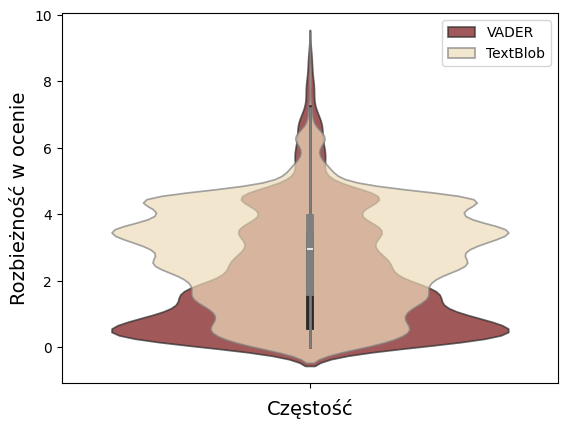

In [21]:
sns.violinplot(y="vader_diff", data=df, color='darkred', alpha=0.7, label="VADER")
sns.violinplot(y="textblob_diff", data=df, color='wheat', alpha=0.7, label="TextBlob")
plt.xlabel('Częstość', fontsize=14)
plt.ylabel('Rozbieżność w ocenie', fontsize=14)
plt.show()

### Przetworzenie przy uzyciu TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
# bag_with_tfidf = tfidf.fit_transform(docs)

def bow_matrix_to_table(matrix, features):
    return pd.DataFrame(data = matrix.toarray(), columns = features)

In [23]:
df.loc[1, ['comment_tokenised']].tolist()[0]

['awesome',
 'far',
 'best',
 'played',
 'yet',
 'ingenious',
 'legacy',
 'system',
 'top',
 'highly',
 'recommended']

In [24]:
tfidf.fit_transform(list(df['comment_preprocessed_2'])[1:10])

<9x189 sparse matrix of type '<class 'numpy.float64'>'
	with 224 stored elements in Compressed Sparse Row format>

In [25]:
df_tfidf = bow_matrix_to_table(tfidf.fit_transform(list(df['comment_preprocessed_2'])), tfidf.get_feature_names_out())

In [92]:
df_tfidf.iloc[:, 10800:]

,multiuse,multiverse,multiyear,multizone,mum,mumble,munchkin,mundane,mundial,mundo,...,zustzlich,zuu,zwaar,zwar,zwei,zweit,zweites,zwischen,zwos,zx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Stworzenie własnego klasyfikatora (las losowy)

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
x_train, x_test, y_train, y_test = train_test_split(df_tfidf, df['rating'], test_size=0.2, random_state=101)

In [30]:
comments_model = RandomForestRegressor(n_estimators=5, random_state=101, verbose=2)

In [31]:
comments_model.fit(x_train, y_train)

building tree 1 of 5
building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


RandomForestRegressor(n_estimators=5, random_state=101, verbose=2)

In [33]:
y_pred = comments_model.predict(x_test)

In [35]:
y_pred

array([5.8       , 8.46689716, 8.46689716, ..., 7.5       , 8.        ,
       8.68066245])

In [49]:
list(y_test[:10])

[5.0, 8.0, 10.0, 10.0, 9.8, 10.0, 5.0, 10.0, 9.0, 7.0]

Index([7849, 6197,   59,  547, 3073,  814, 7921,  356, 4163, 6984,
       ...
       7404, 6198, 7099, 3688, 1234, 4885, 6678, 6121, 7128, 1531],
      dtype='int64', length=1725)

In [56]:
test_idx = x_test.index

In [66]:
df_test = df.loc[test_idx]
df_test['rf_rating'] = y_pred

In [68]:
df_test['rf_diff'] = abs(df_test['rating'] - df_test['rf_rating'])

In [69]:
df_test

,user,rating,comment,comment_preprocessed,comment_preprocessed_2,comment_tokenised,textblob_rating,vader_rating,textblob_diff,vader_diff,rf_rating,rf_diff
7849,Stankiem,5.0,Wow this game is FIDDLY! So much to remember and so much to track. I also need to reference the rulebook constantly even after 2 full playthroughs. The production is not up to snuff as far as making the game simple for players. If the game flowed better maybe I could focus on the gameplay instead of if i'm playing the game correctly. I couldn't sit back and just enjoy the game at any point while playing. The legacy aspects are very cool! Seems like it's well balanced and well thought ...,wow this game is fiddly so much to remember and so much to track i also need to reference the rulebook constantly even after 2 full playthroughs the production is not up to snuff as far as making the game simple for players if the game flowed better maybe i could focus on the gameplay instead of if i am playing the game correctly i could not sit back and just enjoy the game at any point while playing the legacy aspects are very cool seems like it is well balanced and well thought out ...,wow game fiddly much remember much track also need reference rulebook constantly even 2 full playthroughs production snuff far making game simple players game flowed better maybe could focus gameplay instead playing game correctly could sit back enjoy game point playing legacy aspects cool seems like well balanced well thought well despite problems bit fun steam app lots fun,"[wow, game, fiddly, much, remember, much, track, also, need, reference, rulebook, constantly, even, 2, full, playthroughs, production, snuff, far, making, game, simple, players, game, flowed, better, maybe, could, focus, gameplay, instead, playing, game, correctly, could, sit, back, enjoy, game, point, playing, legacy, aspects, cool, seems, like, well, balanced, well, thought, well, despite, problems, bit, fun, steam, app, lots, fun]",5.700000,9.79705,0.700000,4.79705,5.800000,0.800000
6197,handmedown87,8.0,갓-겜 운빨 테마게임을 극혐하지만 이건 인정!,,,[],5.500000,5.50000,2.500000,2.50000,8.466897,0.466897
59,IluvatarIrmo,10.0,x,x,x,[x],5.500000,5.50000,4.500000,4.50000,8.466897,1.533103
547,MasMurda,10.0,Amazing mechanics and an epic adventure!,amazing mechanics and an epic adventure,amazing mechanics epic adventure,"[amazing, mechanics, epic, adventure]",7.075000,8.77105,2.925000,1.22895,9.120000,0.880000
3073,malk1983,9.8,Juanma/Olga 6 juego 4,juanmaolga 6 juego 4,juanmaolga 6 juego 4,"[juanmaolga, 6, juego, 4]",5.500000,5.50000,4.300000,4.30000,9.671489,0.128511
...,...,...,...,...,...,...,...,...,...,...,...,...
4885,Glembidor,9.0,Digital,digital,digital,[digital],5.500000,5.50000,3.500000,3.50000,7.430103,1.569897
6678,Kingsoby1,7.0,"6/8 -> Starting rating is 8/10. I can see it going up. I don't like co-op games much, but this actually was fun. I really like the independent decision making / anti table commander rules (the common bane of all co-ops).",68 starting rating is 810 i can see it going up i do not like coop games much but this actually was fun i really like the independent decision making anti table commander rules the common bane of all coops,68 starting rating 810 see going like coop games much actually fun really like independent decision making anti table commander rules common bane coops,"[68, starting, rating, 810, see, going, like, coop, games, much, actually, fun, really, like, independent, decision, making, anti, table, commander, rules, common, bane, coops]",5.680000,8.73280,1.320000,1.73280,6.400000,0.600000
6121,tituscrowe,8.0,Gloomhaven is quite simply a lot of fun. I have been playing through the campaign with my ten year old and we have added a bit of flair to the game by roleplaying our characters in all scenarios and in experiences in the city and road events. There is a lot of content for any adventurer to sink their teeth into. I love that some of the content has to be unlocked through events in the ga

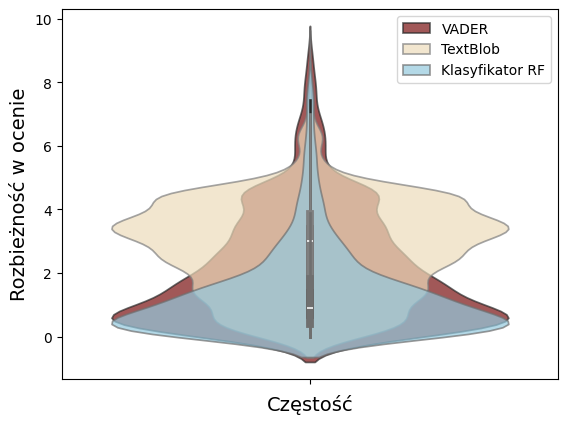

In [70]:
sns.violinplot(y="vader_diff", data=df_test, color='darkred', alpha=0.7, label="VADER")
sns.violinplot(y="textblob_diff", data=df_test, color='wheat', alpha=0.7, label="TextBlob")
sns.violinplot(y="rf_diff", data=df_test, color='skyblue', alpha=0.7, label="Klasyfikator RF")
plt.xlabel('Częstość', fontsize=14)
plt.ylabel('Rozbieżność w ocenie', fontsize=14)
plt.show()